In [4]:
# !unzip bert-base-uncased.zip

In [117]:
# %pip install seaborn

In [125]:
import os
from tqdm import tqdm
from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch_npu
from transformers import BertTokenizer, BertModel

import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
df = pd.read_csv("icd10_categories_descriptions.csv").drop("Unnamed: 0", axis=1)

In [73]:
df.head()

icd10_category                                  description
0            K76                      Other diseases of liver
1            R18                                      Ascites
2            K74              Fibrosis and cirrhosis of liver
3            B19                  Unspecified viral hepatitis
4            J44  Other chronic obstructive pulmonary disease

# BERT sentence embeddings

In [74]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased', cache_dir='./bert-base-uncased/', local_files_only=True)
model = BertModel.from_pretrained('google-bert/bert-base-uncased', cache_dir='./bert-base-uncased/', local_files_only=True, device_map="npu")

/home/ma-user/anaconda3/envs/PyTorch-2.1.0/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [81]:
def get_cls(sentence):
    input_ids = tokenizer(sentence)["input_ids"]
    
    with torch.no_grad():
        outputs = model(torch.tensor(input_ids).unsqueeze(0).npu())
        cls = outputs.last_hidden_state[:, 0, :].cpu()[0]  # [CLS] token

    return np.array(cls)

def get_cls_batch(sentences):
    input_ids = tokenizer(sentences)["input_ids"]
    
    embeddings = []
    # for sentence_ids in tqdm(input_ids):
    for sentence_ids in input_ids:
        with torch.no_grad():
            outputs = model(torch.tensor(sentence_ids).unsqueeze(0).npu())
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu())  # [CLS] token

    return np.array(torch.cat(embeddings))

In [82]:
df["cls"] = df["description"].apply(lambda x: get_cls(x))

In [83]:
df.head()

icd10_category                                  description  \
0            K76                      Other diseases of liver   
1            R18                                      Ascites   
2            K74              Fibrosis and cirrhosis of liver   
3            B19                  Unspecified viral hepatitis   
4            J44  Other chronic obstructive pulmonary disease   

                                                 cls  
0  [-0.29078746, 0.5258369, -0.62045944, -0.40679...  
1  [-0.4252156, 0.038987596, -0.4122528, -0.14901...  
2  [-0.6999419, 0.16442183, -0.60357517, -0.52825...  
3  [-0.42382884, 0.08339923, -0.6981253, -0.34307...  
4  [-0.4592635, 0.18747547, -0.66181934, -0.76231...

In [88]:
df.to_csv("bert_embeddings.tsv", sep="\t")

In [105]:
similarity_scores = cosine_similarity(list(df["cls"].values), list(df["cls"].values))

In [107]:
similarity_scores = pd.DataFrame(data=similarity_scores, index=df["icd10_category"].values, columns=df["icd10_category"].values)

In [128]:
similarity_scores = similarity_scores.sort_index().sort_index(axis=1)

In [129]:
similarity_scores

A01       A02       A03       A04       A05       A06       A07  \
A01  1.000001  0.859075  0.666252  0.858970  0.823209  0.738721  0.829739   
A02  0.859075  1.000000  0.778066  0.973230  0.887739  0.864728  0.942118   
A03  0.666252  0.778066  1.000000  0.791396  0.790527  0.919051  0.805557   
A04  0.858970  0.973230  0.791396  1.000000  0.898024  0.869329  0.958388   
A05  0.823209  0.887739  0.790527  0.898024  0.999999  0.848472  0.881998   
..        ...       ...       ...       ...       ...       ...       ...   
Z95  0.779754  0.787913  0.657126  0.789605  0.779478  0.707618  0.810198   
Z96  0.763720  0.850432  0.758232  0.861209  0.833239  0.816915  0.868797   
Z97  0.739030  0.855871  0.780746  0.881406  0.858138  0.843026  0.869339   
Z98  0.708702  0.834248  0.834849  0.863679  0.860578  0.872588  0.880598   
Z99  0.748625  0.813535  0.778442  0.832695  0.881463  0.829221  0.831295   

          A08       A09       A15  ...       Z90       Z91       Z92  \
A01  0.882886  0.872616  0.820204  ...  0.805431  0.770934  0.720138   
A02  0.934124  0.913692  0.822071  ...  0.834017  0.822645  0.804432   
A03  0.738944  0.729135  0.668764  ...  0.776086  0.733131  0.760433   
A04  0.949403  0.909557  0.811084  ...  0.844010  0.828375  0.841727   
A05  0.885303  0.877407  0.823802  ...  0.887322  0.865898  0.805541   
..        ...       ...       ...  ...       ...       ...       ...   
Z95  0.841388  0.840788  0.831706  ...  0.832133  0.812769  0.785738   
Z96  0.868825  0.858490  0.789262  ...  0.877052  0.840590  0.855177   
Z97  0.857849  0.833856  0.767897  ...  0.872913  0.860400  0.861113   
Z98  0.802457  0.784911  0.705052  ...  0.826473  0.798278  0.857564   
Z99  0.832144  0.822429  0.778005  ...  0.910030  0.905899  0.840894   

          Z93       Z94       Z95       Z96       Z97       Z98       Z99  
A01  0.700661  0.752214  0.779754  0.763720  0.739030  0.708702  0.748625  
A02  0.820511  0.804258  0.787913  0.850432  0.855871  0.834248  0.813535  
A03  0.809154  0.733271  0.657126  0.758232  0.780746  0.834849  0.778442  
A04  0.840908  0.817086  0.789605  0.861209  0.881406  0.863679  0.832695  
A05  0.821158  0.816779  0.779478  0.833239  0.858138  0.860578  0.881463  
..        ...       ...       ...       ...       ...       ...       ...  
Z95  0.751811  0.864184  1.000000  0.915228  0.826006  0.707922  0.791651  
Z96  0.866958  0.886410  0.915228  1.000001  0.935892  0.838621  0.851456  
Z97  0.897608  0.848627  0.826006  0.935892  1.000000  0.869510  0.886233  
Z98  0.886528  0.794292  0.707922  0.838621  0.869510  1.000000  0.863307  
Z99  0.867307  0.834355  0.791651  0.851456  0.886233  0.863307  1.000000  

[1696 rows x 1696 columns]

In [130]:
similarity_scores.to_csv("similarity_scores.csv")

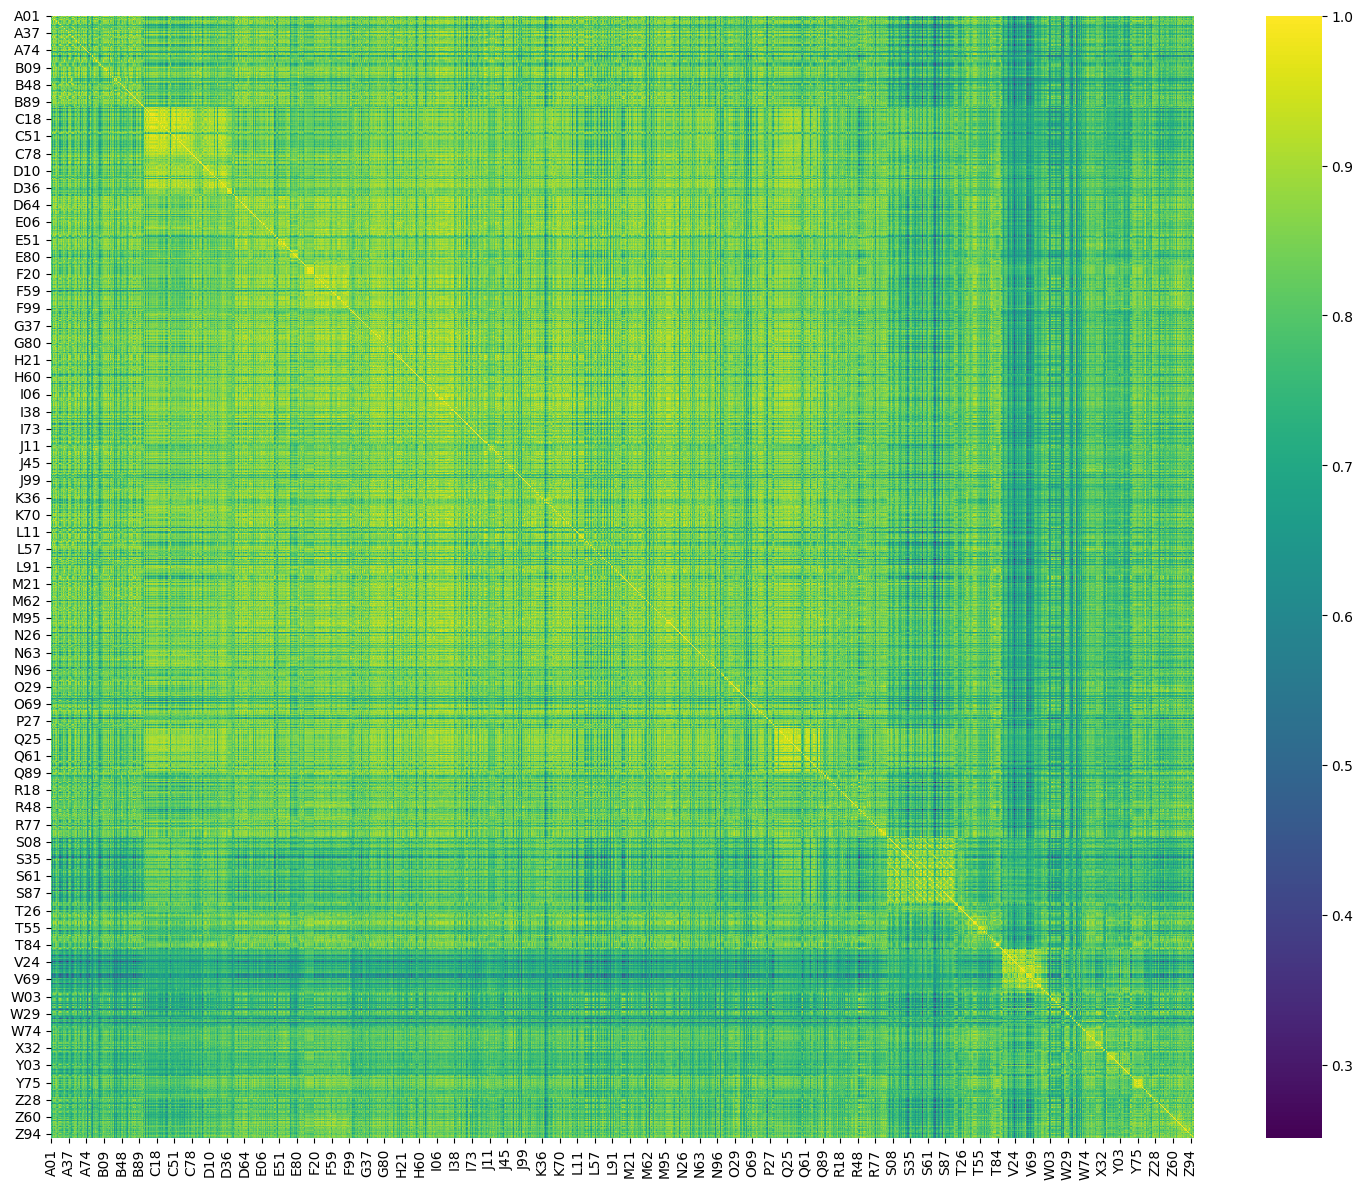

In [133]:
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_scores, cmap ='viridis')
plt.tight_layout()
plt.savefig("pics/cosine_similarity.png", dpi=300, bbox_inches='tight')
plt.show()